<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 0 - Introducción a Redes Neuronales </H3>
<div align='center'>
###  Felipe González - 201273534-3 
### Ignacio Tampe - 201573514-k 
</div>
<hr style="height:2px;border:none"/>

In [28]:
import numpy as np
import random
import time
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import keras
%matplotlib inline

## 1. Back-propagation (BP) from *Scratch*

Para la realización de la primera parte de la tarea, se implementó una clase red neuronal basada en SGD con activación de la última capa con softmax, la cual permite mayor modularización su estructura, tanto en tamaño y cantidad de capas, como en la función de activación y costo de ésta.

Así se crearon las clases: RedNeuronal, CapaNeuronal y Neurona.

Para instanciar una red neuronal se realiza de la siguiente forma:
```python
nn = RedNeuronal(num_entrada, tam_capas, num_salida, act_inter, cost_func)
```
Donde los parámetros son:
>* **num_entrada**: dimension de los vectores de entrada.
>* **tam_capas**: lista de cantidad de neuronas por cada capa interna, [32, 16], también indica la cantidad de capas internas.
>* **num_salida**: dimension de los vectores de salida.
>* **act_inter**: función de activación de capas internas: "sigmoid" / "relu" / "arctan" / "softmax".
>* **cost_func**: función de costo: "crossentropy" / "mse".

La implementación que incluye *Forward pass*, *Backward pass* y rutina de entretamiento se encuentra a continuación.

Tanto *Forward pass* y *Backward pass* están implementados dentro del método correspondiente a la rutina de entrenamiento.

In [1]:
class RedNeuronal:
    
    # num_entrada: dimension de los vectores de entrada, en iris: 4
    # tam_capas: lista de cantidad de neuronas por cada capa interna, en iris: [32, 16]
    # num_salida: dimension de los vectores de salida, en iris: 3
    # act_inter: función de activación de capas internas: "sigmoid" / "relu" / "arctan" / "softmax"
    # cost_func: función de costo: "crossentropy" / "mse" 
    def __init__(self, num_entrada, tam_capas, num_salida, act_inter, cost_func):
        self.num_entrada = num_entrada
        self.tam_capas = tam_capas
        self.num_salida = num_salida
        self.capas = []
        self.log = dict()
        # iniciar todas las capas inicial - ocultas - final
        self.capas.append(CapaNeuronal(num_entrada, act_inter))
        for i in range(len(tam_capas)):
            self.capas.append(CapaNeuronal(tam_capas[i], act_inter, self.capas[i].tam_capa))
        self.capas.append(CapaNeuronal(num_salida, "softmax", self.capas[len(self.capas)-1].tam_capa))
        self.cant_capas = len(self.capas)
        if cost_func == "crossentropy":
            self.cost = self.crossentropy
            self.cost_derivative = self.crossentropy_derivative
        elif cost_func == "mse":
            self.cost = self.mse
            self.cost_derivative = self.mse_derivative
        print("Red Neuronal creada")
        print("\tCapas:", num_entrada, tam_capas, num_salida)
        print("\tActivación interna:", act_inter)
        print("\tFunción de costo:", cost_func)

    def crossentropy(self, prediccion, esperado, epsilon=1e-12): #El epsilon evita log(0)
        prediccion = np.clip(prediccion, epsilon, 1. - epsilon)
        N = prediccion.shape[0]
        ce = -np.sum(np.sum(esperado*np.log(prediccion+epsilon)))/N
        return ce
    
    def crossentropy_derivative(self, prediccion, esperado, squash_prime, vector_z):
        return prediccion-esperado

    def mse(self, prediccion, esperado):
        return 0.5*np.dot(prediccion-esperado, prediccion-esperado)
    
    def mse_derivative(self, prediccion, esperado, squash_prime, vector_z):
        return (prediccion-esperado) * squash_prime(vector_z)
    
    # train(entrada, salida, ciclos, tasa):
    # entrada: lista de datos de entrada.
    # salida: lista de vectores de salida tipo onehot.
    # ciclos: cantidad de epochs.
    # tasa: tasa de aprendizaje .
    # verbose: Booleano que indica progreso por epoch o solo el final.
    # momentum: agrega la posibilidad de entrenar con momentum, recibe el valor de éste.
    def train(self, entrada, salida, ciclos, tasa, verbose = False, momentum = None):
        last = self.cant_capas-1 # indice capa de salida
        result = zip(entrada,salida)
        resultList = list(result)
        loss = []
        accuracy = []
        tiempo = []
        print("Comienza entrenamiento de red", end=" ")
        if momentum:
            print("con momentum", momentum)
        else:
            print()
        for ciclo in range(ciclos):
            # Comienza 1 epoch
            random.shuffle(resultList)
            errores = []
            acertados = 0
            primera_iter = True
            lista_delta_pesos = list(np.zeros(self.cant_capas))
            start = time.time()
            for input_v, output in resultList:
                #Poblar capa inicial
                self.capas[0].set_capa(input_v, input_v) 
                
                # Feed forward 
                for j in range(1, len(self.capas)):
                    self.capas[j].feed_forward(self.capas[j-1])
                
                # evaluar error final (delta función costo)
                prediccion = self.capas[last].get_activaciones()
                error_epoch = self.cost(self.capas[last].get_activaciones(), output)
                errores.append(error_epoch)
                
                if (np.argmax(prediccion) == np.argmax(output)):
                    acertados += 1
                
                #Backward pass capa final
                delta = self.cost_derivative(prediccion, np.transpose(output), self.capas[last].squash_derivative, self.capas[last].get_vector_z())
                
                self.capas[last].actualizar_bias(delta, tasa)
                
                delta_peso = np.outer(self.capas[last-1].get_activaciones(), delta)
                
                if momentum:
                    if primera_iter:
                        self.capas[last].actualizar_pesos(delta_peso, tasa)
                    else:
                        self.capas[last].actualizar_pesos_momentum(delta_peso, tasa, momentum, lista_delta_pesos[last])
                    lista_delta_pesos[last] = tasa*delta_peso
                else:
                    self.capas[last].actualizar_pesos(delta_peso, tasa)
                #Backward pass general
                for l in range(2, self.cant_capas):
                    z = self.capas[-l].get_vector_z()
                    act_prime = self.capas[-l].squash_derivative(z)
                    delta = np.dot(self.capas[-l+1].get_pesos(), delta.transpose()) * act_prime
                    delta_peso = np.outer(self.capas[-l-1].get_activaciones(),delta)
                    
                    self.capas[-l].actualizar_bias(delta, tasa)
                    if momentum:
                        if primera_iter:
                            self.capas[-l].actualizar_pesos(delta_peso, tasa)
                        else:
                            self.capas[-l].actualizar_pesos_momentum(delta_peso, tasa, momentum, lista_delta_pesos[-l])
                        #Actualizacion de lista de pesos
                        lista_delta_pesos[-l] = np.outer(self.capas[-l-1].get_activaciones(), delta)
                    else:
                        self.capas[-l].actualizar_pesos(delta_peso, tasa)
                        
                primera_iter = True
            loss.append(np.mean(errores))
            accuracy.append(acertados/len(resultList))
            tiempo.append(time.time()-start)
            primera_ter = False
            if verbose:
                print("\tError del epoch "+str(ciclo)+": loss", str(np.round(np.mean(errores),5)),"- acc", acertados/len(resultList))
        print("Resultado de training set de", ciclos,"epochs: loss", np.mean(errores),"- acc:", acertados/len(resultList))
        self.log['loss'] = loss
        self.log['accuracy'] = accuracy
        self.log['tiempo'] = tiempo

    # test(entrada, salida):
    # entrada: lista de datos de entrada de test.
    # salida: Lista de datos esperados de test, en formato onehot vector.
    # retorna listas de predicciones y valores esperados.
    def test(self, entrada, salida):
        # repetir para todas 
        last = self.cant_capas-1 # indice capa de salida
        result = zip(entrada,salida)
        resultList = list(result)
        errores = []
        acertados = 0
        lista_pred = []
        lista_res = []
        for input_v, output in resultList:
            self.capas[0].set_capa(input_v, input_v) #Poblar capa inicial
            # Feed forward 
            for j in range(1, len(self.capas)):
                self.capas[j].feed_forward(self.capas[j-1])

            
            prediccion = self.capas[last].get_activaciones()
            
            if (np.argmax(prediccion) == np.argmax(output)):
                    acertados += 1
            lista_pred.append(np.argmax(prediccion))
            lista_res.append(np.argmax(output))
            # evaluar error final (delta función costo)
            error_epoch = self.cost(prediccion, output)
            errores.append(error_epoch)
        
        print("Error del test: loss", str(np.round(np.mean(errores),5)),"- acc", acertados/len(resultList))
        return lista_pred, lista_res
    
    # predict(entrada, categorias):
    # entrada: Vector de entrada para predecir
    # categorias: Etiquetas correspondientes a las categorias
    # retorna la etiqueta correspondiente a la predicción de la red neuronal 
    def predict(self, entrada, categorias):
        last = self.cant_capas-1
        self.capas[0].set_capa(entrada, entrada)
        
        for j in range(1, len(self.capas)):
                self.capas[j].feed_forward(self.capas[j-1])
        
        prediccion = self.capas[last].get_activaciones()
        
        return categorias[np.argmax(prediccion)]

In [17]:
class CapaNeuronal:
    def __init__(self, tam_capa, tipo, tam_anterior = 0):
        self.tam_capa = tam_capa
        self.tam_anterior = tam_anterior
        self.bias = 1
        self.neuronas = [Neurona(tam_anterior) for i in range(tam_capa)] # lista de neuronas de la capa
        if tipo == "sigmoid":
            self.squash = self.sigmoid
            self.squash_derivative = self.sigmoid_derivative
        elif tipo == "softmax":
            self.squash = self.softmax
            self.squash_derivative = self.softmax_derivative
        elif tipo == "arctan":
            self.squash = self.arctan
            self.squash_derivative = self.arctan_derivative
        elif tipo == "relu":
            self.squash = self.relu
            self.squash_derivative = self.relu_derivative
       
    def sigmoid(self, x):
        return np.array([np.where(i > 0, 1. / (1. + np.exp(-i)), np.exp(i) / (np.exp(i) + np.exp(0))) for i in x])
    
    def sigmoid_derivative(self, x):
        return np.multiply(self.sigmoid(x),(1-self.sigmoid(x)))
    
    def arctan(self, x):
        return np.arctan(x)
    
    def arctan_derivative(self, x):
        return np.power(np.cos(x),2)
        
    def relu(self, x):
        x= np.array(x)
        return np.maximum(x, 0, x)
    
    def relu_derivative(self, x):
        x = np.array(x)
        return (x > 0).astype(int)
    
    def softmax(self, x):
        X = np.clip(x,-350,350)
        x = np.exp(x-np.max(x))
        return x / np.sum(x, axis=0)
    
    def softmax_derivative(self, x):
        x = np.clip(x, -350, 350)
        res = []
        for i in x:
            res.append(np.exp(i)*(np.sum(np.exp(x), axis=0)-np.exp(i))/(np.sum(np.exp(x), axis=0)**2))
        #print(x)
        return np.array(res)
    
    def get_activaciones(self):
        return np.array([neurona.activacion for neurona in self.neuronas])
    
    def get_vector_z(self):
        return [neurona.z for neurona in self.neuronas]
    
    
    def feed_forward(self, capa_anterior):
        pre_squash = []
        activaciones = capa_anterior.get_activaciones()
        vector_z = capa_anterior.get_vector_z()
        for neurona in self.neuronas:
            pesos = neurona.pesos
            pre_squash.append(np.dot(pesos, activaciones) + neurona.bias)
        self.set_capa(self.squash(pre_squash), pre_squash)
   
    def get_pesos(self):
        return np.transpose(np.array([n.pesos for n in self.neuronas]))

    def actualizar_pesos(self, matriz, rate, momentum = 0, prev_delta_pesos = 0):
        pesos = np.transpose(np.array([n.pesos for n in self.neuronas]))
        pesos -= rate*matriz + momentum*prev_delta_pesos
        for i in range(len(self.neuronas)):
            self.neuronas[i].pesos = pesos[:,i]
    
    def actualizar_bias(self, vector_b, rate):
        biases = np.array([n.bias for n in self.neuronas])
        biases -= rate*vector_b #SE PUSO SUMA PORQUE BAJABA EL ERROR DEL EPOCH
        for i in range(len(self.neuronas)):
            self.neuronas[i].bias = biases[i]
    
    #Funcion para poblar datos de entrada a la red.
    def set_capa(self, activaciones, vector_z):
        for i in range(len(self.neuronas)):
            self.neuronas[i].set_activacion(activaciones[i], vector_z[i])
            
    def mostrar_capa(self):
        for neurona in self.neuronas:
            print(neurona, end="\t")
        print("\n-----------------------------")

        
class Neurona:
    def __init__(self, tam_capa_anterior):
        self.pesos = np.random.rand(tam_capa_anterior) # genera una lista de numeros aleatorios de tamaño "tam_capa_anterior"
        self.bias = np.random.rand()
        
    def set_activacion(self, valor_a, valor_z):
        self.activacion = valor_a
        self.z = valor_z
        
    def __str__(self):
        return "Activación: "+str(self.activacion)

Para poder probar el funcionamiento de la red neuronal se debe instanciar y llamar al método en entrenamiento de la siguiente forma:

```python
nn.train(entrada, salida, ciclos, tasa)
```

>* **entrada**: lista de datos de entrada.
>* **salida**: lista de vectores de salida tipo onehot.
>* **ciclos**: cantidad de epochs.
>* **tasa**: tasa de aprendizaje .
>* **verbose**: Booleano que indica progreso por epoch o solo el final. (keyword argument, Default: False)

Esta función tomará el dataset entregado y ejecutará una rutina de Feed Forward -> Cálculo de error -> Backpropagation por la cantidad de ciclos necesaria, mezclando en cada ciclo los datos de forma aleatoria para minimizar sesgo.

### 1.b) Predicciones utilizando feed forward

Una vez entrenada la red, se puede utilizar para realizar predicciones de la siguiente forma:
```python
categorias = ['setosa', 'versicolor', 'verginica']
for entrada in x_test:
    prediccion = nn.predict(entrada, categorias)
```
Esta función tomará una entrada e intentará realizar una predicción mediante *Feed Forward*, retornando la etiqueta correspondiente.

### 1.c) Probar la implementación en un problema de clasificación.

Para probar nuestra implementación de red neuronal se utliza el dataset iris el cual se normaliza y se separa en un *training set* y un *testing set*.

In [13]:
#Carga y estructuración de datos
x, y = load_iris(return_X_y=True)
scaler = StandardScaler().fit(x)
x = scaler.transform(x) 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=50)
y_onehot_train = keras.utils.to_categorical(y_train)
y_onehot_test = keras.utils.to_categorical(y_test)
tags = ['setosa', 'versicolor', 'verginica']

Con los datos cargados se procede a instanciar las 4 redes neuronales a evaluar, utilizando *sigmoid* o ReLU como función de activación y usando MSE o Cross Entropy como función de costo:

Las funciones de activación están implementadas dentro de la clase CapaNeuronal junto con sus derivadas.

Las funciones de costo están implementadas dentro de la clase RedNeuronal junto con sus derivadas.

In [54]:
# Instanciar redes neuronales
nn_sm = RedNeuronal(4, [32, 16], 3, "sigmoid", "mse")
nn_sc = RedNeuronal(4, [32, 16], 3, "sigmoid", "crossentropy")
nn_rm = RedNeuronal(4, [32, 16], 3, "relu", "mse")
nn_rc = RedNeuronal(4, [32, 16], 3, "relu", "crossentropy")

Red Neuronal creada
	Capas: 4 [32, 16] 3
	Activación interna: sigmoid
	Función de costo: mse
Red Neuronal creada
	Capas: 4 [32, 16] 3
	Activación interna: sigmoid
	Función de costo: crossentropy
Red Neuronal creada
	Capas: 4 [32, 16] 3
	Activación interna: relu
	Función de costo: mse
Red Neuronal creada
	Capas: 4 [32, 16] 3
	Activación interna: relu
	Función de costo: crossentropy


Luego se procede a entrenar cada una de las redes con 100 *epochs* y un *learning rate* $\eta = 0.1$

Tras esto se extraen los datos del registro de entrenamiento:

In [55]:
#Entrenar la red 
nn_sm.train(x_train, y_onehot_train, 100, 0.1)
nn_sc.train(x_train, y_onehot_train, 100, 0.1)
nn_rm.train(x_train, y_onehot_train, 100, 0.1)
nn_rc.train(x_train, y_onehot_train, 100, 0.1)

loss_sm = nn_sm.log['loss']
accuracy_sm = nn_sm.log['accuracy']
tiempo_sm = nn_sm.log['tiempo']

loss_sc = nn_sc.log['loss']
accuracy_sc = nn_sc.log['accuracy']
tiempo_sc = nn_sc.log['tiempo']

loss_rm = nn_rm.log['loss']
accuracy_rm = nn_rm.log['accuracy']
tiempo_rm = nn_rm.log['tiempo']

loss_rc = nn_rc.log['loss']
accuracy_rc = nn_rc.log['accuracy']
tiempo_rc = nn_rc.log['tiempo']

Comienza entrenamiento de red 
Resultado de training set de 100 epochs: loss 0.105255694435 - acc: 0.95
Comienza entrenamiento de red 
Resultado de training set de 100 epochs: loss 0.0205860834225 - acc: 0.99
Comienza entrenamiento de red 
Resultado de training set de 100 epochs: loss 0.659999999995 - acc: 0.34
Comienza entrenamiento de red 


C:\Users\thena\Anaconda2\envs\rna\lib\site-packages\numpy\core\numeric.py:1154: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis,:], out)
C:\Users\thena\Anaconda2\envs\rna\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\thena\Anaconda2\envs\rna\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in maximum
C:\Users\thena\Anaconda2\envs\rna\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater


Resultado de training set de 100 epochs: loss nan - acc: 0.33


Tras entrenar las redes, se procede a graficar la función objetivo "Loss" y la precisión de clasificación:

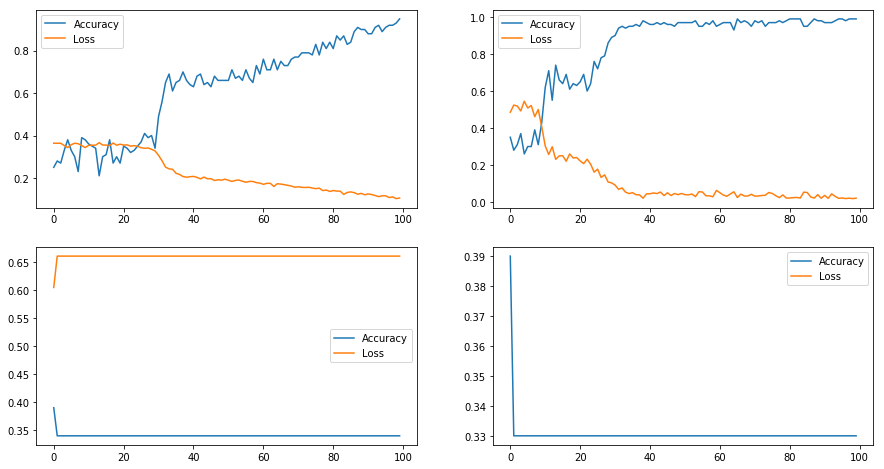

Tiempo total para activación sigmoid y costo MSE 15.351
Tiempo total para activación sigmoid y costo Cross Entropy 16.636
Tiempo total para activación ReLU y costo MSE 5.296
Tiempo total para activación ReLU y costo Cross Entropy 5.473


In [56]:
plt.figure(1, figsize=(15,8))
plt.subplot(221)
plt.plot(range(len(accuracy_sm)), accuracy_sm, label="Accuracy")
plt.plot(range(len(loss_sm)), loss_sm, label="Loss")
plt.legend()
plt.subplot(222)
plt.plot(range(len(accuracy_sc)), accuracy_sc, label="Accuracy")
plt.plot(range(len(loss_sc)), loss_sc, label="Loss")
plt.legend()
plt.subplot(223)
plt.plot(range(len(accuracy_rm)), accuracy_rm, label="Accuracy")
plt.plot(range(len(loss_rm)), loss_rm, label="Loss")
plt.legend()
plt.subplot(224)
plt.plot(range(len(accuracy_rc)), accuracy_rc, label="Accuracy")
plt.plot(range(len(loss_rc)), loss_rc, label="Loss")
plt.legend()
plt.show()

print("Tiempo total para activación sigmoid y costo MSE", round(np.sum(tiempo_sm),3))
print("Tiempo total para activación sigmoid y costo Cross Entropy", round(np.sum(tiempo_sc),3))
print("Tiempo total para activación ReLU y costo MSE", round(np.sum(tiempo_rm),3))
print("Tiempo total para activación ReLU y costo Cross Entropy", round(np.sum(tiempo_rc),3))

Se puede ver como la configuración Sigmoid y Cross-Entropy entrega resultados notoriamente mejores tanto para precisión de clasificación y minización de la función de pérdida, obteniéndose en algunos casos una accuracy cercana al 99%.

Además se desprende que la combinación ReLU y Cross Entropy es la más rápida, siendo cada una de estas la más rápida de su categoría (activación y costo) con un aumento de más de 4 veces la velocidad repecto a la configuración más lenta.

### Matriz de confusión para test con red de activación sigmoide y costo Cross-Entropy

Además de las funciones mencionadas previamente, se creó un método para hacer una rutina de testing y evaluar loss y accuracy con un dataset desconocido para la red neuronal:

```python
nn.test(entrada, salida)
```
Los parámetros de la función son
>* entrada: lista de datos de entrada de test
>* salida: Lista de datos esperados de test, en formato onehot vector

retorna listas de resultados predichos y esperados para poder realizar un análisis de confusión.

al probar esto se tiene:

Error del test: loss 0.06864 - acc 0.94
Normalized confusion matrix
[[ 1.          0.          0.        ]
 [ 0.          0.82352941  0.17647059]
 [ 0.          0.          1.        ]]


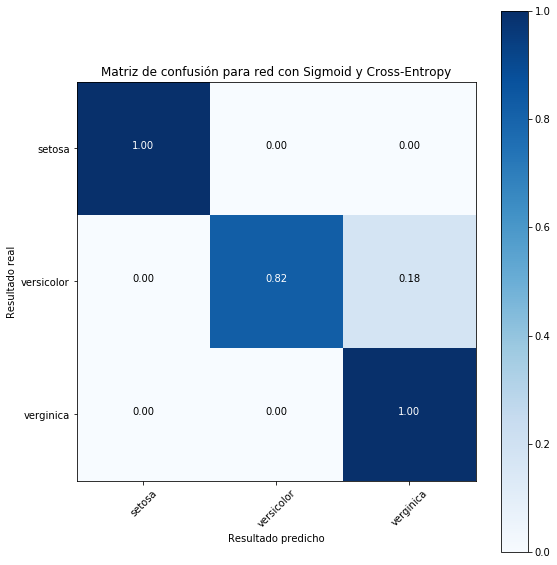

In [57]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Resultado real')
    plt.xlabel('Resultado predicho')
    
pred, real = nn_sc.test(x_test, y_onehot_test)
cnf_matrix = confusion_matrix(real, pred)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=tags, normalize=True,
                      title='Matriz de confusión para red con Sigmoid y Cross-Entropy')

De la matriz se desprende que solo un pequeño porcentaje del test falló, ya que la red predijo que era una planta del tipo "Verginica" cuadno en realidad era de tipo "Versicolor".

Fuera de esto, el resto de las predicciones no fallaron obteniéndose un 100% de precisión en algunos casos, como se ve en la diagonal de la matriz.